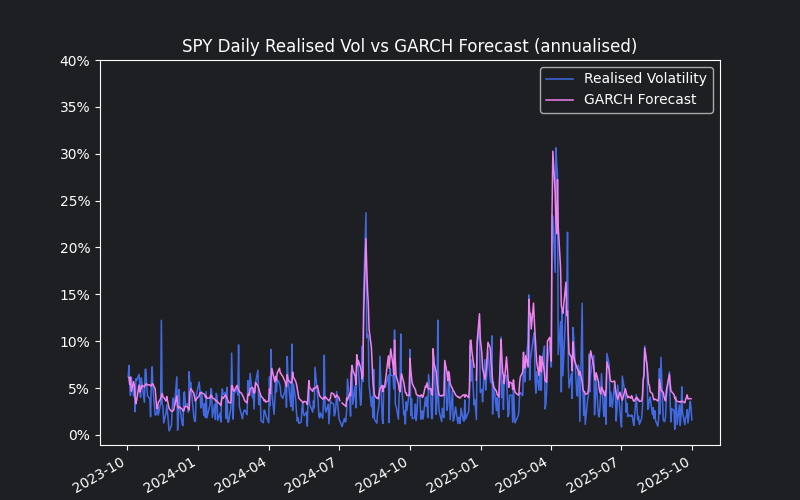

In [35]:
#DAILY GARCH

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import ticker
import matplotlib.dates as mdates
from arch import arch_model
%matplotlib widget
plt.rcParams.update(
    {"axes.facecolor": "#1e1f22", "figure.facecolor": "#1e1f22", "axes.edgecolor": "#ffffff", "text.color": "#ffffff","xtick.color":"#ffffff","ytick.color":"#ffffff"})

#INPUTS
symbol = "SPY"
lookback = "2y" #period to analyse; one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]
t_days = 252 #number of trading days in a year

#COLLECT
df = DataFrame(yf.Ticker(symbol).history(period = lookback, interval = "1h")["Close"]) #seven 1hr periods per trading day
df["Return"] = np.log(df["Close"] / df["Close"].shift(1))
vols = DataFrame(index = np.unique(df.index.date))
vols["Realised"] = df["Return"].groupby(df.index.date).std()*np.sqrt(t_days)

#GARCH
forecasts = {}
basic_gm = arch_model(df["Return"].iloc[1:]*1000, p = 1, o = 1, q = 1, mean = "constant", vol = "GARCH", dist = "skewt")

for i in range(7,len(df["Return"])-1,7):
    res = basic_gm.fit(last_obs = i, disp = "off", options = {"maxiter": 300,"ftol": 1e-07})
    gm_forecast = res.forecast(horizon = 7).variance.iloc[0,:]
    agg_vol = np.sqrt((gm_forecast.values/1000000).mean())*np.sqrt(t_days)
    forecasts[gm_forecast.name.date()] = agg_vol

vols["Forecast Vol"] = forecasts

#PLOT
fig, ax = plt.subplots()
ax.plot(vols["Realised"], "royalblue", linewidth=1.1)
ax.plot(vols["Forecast Vol"], "violet", linewidth=1.1)
fig.legend(labels=["Realised Volatility", "GARCH Forecast"], bbox_to_anchor=(0.9, 0.88))
plt.setp(ax.get_xticklabels(), rotation=30, horizontalalignment='right')
plt.ylim(top=np.ceil(max(vols["Realised"].dropna().max(), vols["Forecast Vol"].dropna().max())*10)/10)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
ax.format_xdata = mdates.DateFormatter("%Y-%m-%d").format_data
ax.set_title(f"{symbol} Daily Realised Vol vs GARCH Forecast (annualised)")
fig.set_figwidth(8), fig.set_figheight(5)
fig.canvas.toolbar_visible = False
plt.show();

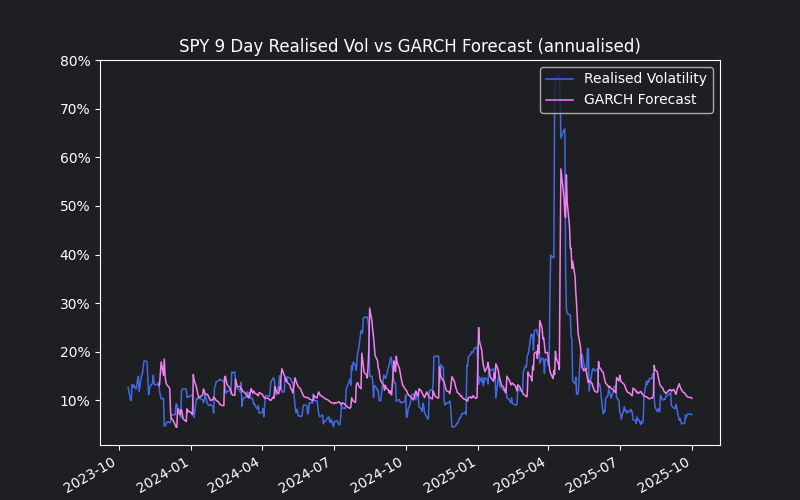

In [39]:
#X PERIOD GARCH

import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from pandas import DataFrame
from matplotlib import ticker
import matplotlib.dates as mdates
from arch.univariate import arch_model
%matplotlib widget
plt.rcParams.update({"axes.facecolor":"#1e1f22","figure.facecolor":"#1e1f22","axes.edgecolor":"#ffffff","text.color":"#ffffff"})

#INPUTS
symbol = "SPY"
period = 9 #no. days to forecast
lookback = "2y" #period to analyse; one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]
t_days = 252 #number of trading days in a year

#COLLECT
df = DataFrame(yf.Ticker(symbol).history(period = lookback)["Close"])
df["Return"] = np.log(df["Close"]/df["Close"].shift(1))
df["Realised Vol"] = df["Return"].rolling(period).std()*np.sqrt(t_days)

#GARCH
forecasts = {}
basic_gm = arch_model(df["Return"].iloc[1:]*1000, p = 1, o = 1, q = 1, mean = "constant", vol = "GARCH", dist = "skewt")

for i in range(period*3,len(df["Return"])-period):
    res = basic_gm.fit(last_obs = i, disp = "off", options = {"maxiter": 400,"ftol": 1e-07})
    gm_forecast = res.forecast(horizon = period).variance.iloc[0,:].values/1000000 #daily variances
    agg_vol = np.sqrt(gm_forecast.mean())*np.sqrt(t_days)
    forecasts[df.index[i+period]] = agg_vol
df["Forecast Vol"] = forecasts

#PLOT
fig, ax = plt.subplots()
ax.plot(df["Realised Vol"], "royalblue", linewidth = 1.1)
ax.plot(df["Forecast Vol"], "violet", linewidth = 1.1)
fig.legend(labels = ["Realised Volatility","GARCH Forecast"], bbox_to_anchor = (0.9,0.88))
plt.setp(ax.get_xticklabels(), rotation = 30, horizontalalignment = "right")
plt.ylim(top=np.ceil(max(df["Realised Vol"].dropna().max(), df["Forecast Vol"].dropna().max())*10)/10)
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax = 1, decimals = 0))
ax.format_xdata = mdates.DateFormatter("%Y-%m-%d").format_data
ax.set_title(f"{symbol} {period} Day Realised Vol vs GARCH Forecast (annualised)")
fig.set_figwidth(8), fig.set_figheight(5)
fig.canvas.toolbar_visible = False
plt.show();

In [25]:
#X PERIOD ARIMA

import pandas as pd
from pandas import DataFrame, Series
import numpy as np
import yfinance as yf
import statsmodels.api as sm
import matplotlib.pyplot as plt


#INPUTS
symbol = "SPY"
period = 9 #no. days to forecast
lookback = "1y" #period to analyse; one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]
t_days = 252 #number of trading days in a year

#COLLECT
df = DataFrame(yf.Ticker(symbol).history(period = lookback, interval = "1d")["Close"])
df["Return"] = np.log(df["Close"]/df["Close"].shift(1)) #daily log returns
df = df.asfreq("B")

#ARIMA
arima = sm.tsa.arima.ARIMA(df["Return"].asfreq("B"), order = (1,1,1), enforce_stationarity = False)
res = arima.fit(method_kwargs = {"maxiter": 300})
fore = res.forecast(steps = period)
agg_return = fore.values.mean()*t_days
print(f"ARIMA Forecast (annualised): {"{:.2%}".format(agg_return)}\n"
      f"Return over last {lookback} (annualised): {"{:.2%}".format(df["Return"].mean()*t_days}")

ARIMA Forecast (annualised): 17.20%
Return over last 1y (annualised): 17.56%


Mean return over last 2y (annualised): 22.35%
9 day ARIMA return forecast (annualised): 22.31%

Realised volatility over last 2y (annualised): 15.66%
9 day GARCH volatility forecast (annualised): 13.96%

Current price: 668.45
Day 9 mean forecast price: 675.98
Forecast 10th percentile: 649.326 (mean -26.652)
Forecast 90th percentile: 699.003 (mean +23.025)


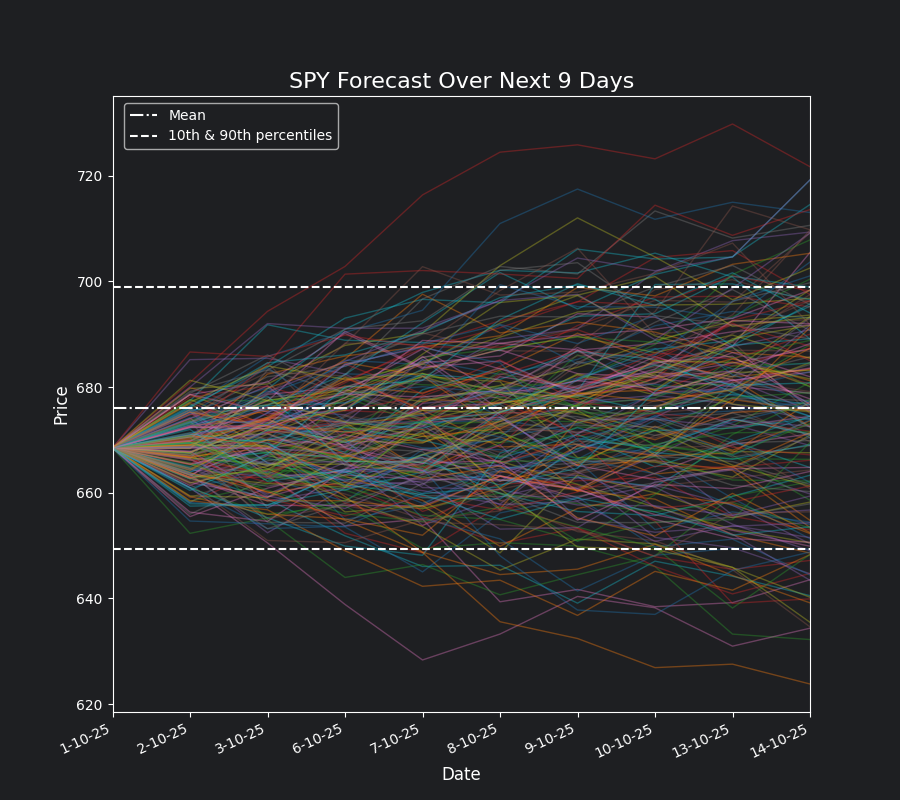

In [2]:
#GBM PRICE FORECAST

import pandas as pd
import numpy as np
import yfinance as yf
import matplotlib.pyplot as plt
import statsmodels.api as sm
from pandas import DataFrame
from GBM import GBM
from arch.univariate import arch_model
%matplotlib widget
plt.rcParams.update(
    {"axes.facecolor": "#1e1f22", "figure.facecolor": "#1e1f22", "axes.edgecolor": "#ffffff", "text.color": "#ffffff","xtick.color":"#ffffff","ytick.color":"#ffffff"})

#INPUTS
symbol = "SPY"
period = 9 #no. days to forecast
lookback = "2y" #period to analyse; one of: [1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd, max]
t_days = 252 #number of trading days in a year
percentiles = [0.10, 0.90] #percentiles to calculate on final price forecast. In the form: [a,b], a > b

#COLLECT
current = yf.Ticker(symbol).info["regularMarketPrice"]
df = DataFrame(yf.Ticker(symbol).history(period=lookback, interval = "1h")["Close"]) #seven 1hr periods per trading day (6.5 hours in truth)
df["Return"] = np.log(df["Close"]/df["Close"].shift(1))
returns = np.log(df["Close"].groupby(df.index.date).first().dropna()/df["Close"].groupby(df.index.date).first().dropna().shift(1)) #daily log returns
returns = returns.asfreq("B")

#ARIMA
arima = sm.tsa.arima.ARIMA(returns, order = (1,1,1), enforce_stationarity = False)
res = arima.fit(method_kwargs = {"maxiter": 300})
fore = res.forecast(steps = period)
agg_return = fore.values.mean()*t_days

#GARCH
forecasts = {}
basic_gm = arch_model(df["Return"].iloc[1:]*1000, p = 1, o = 1, q = 1, mean = "constant", vol = "GARCH", dist = "skewt")
res = basic_gm.fit(disp = "off", options = {"maxiter": 300,"ftol": 1e-07})
gm_forecast = res.forecast(horizon = period*7).variance.iloc[0,:] #hourly variance
agg_vol = np.sqrt((gm_forecast.values/1000000).mean())*np.sqrt(t_days*6.5)

#GBM
walks = GBM(current, agg_return, agg_vol, 200, period)
mean_fore = DataFrame(walks).iloc[:,-1].mean()
l_percentile = DataFrame(walks).iloc[:,-1].quantile(percentiles[0])
u_percentile = DataFrame(walks).iloc[:,-1].quantile(percentiles[1])

#PLOT
fig, ax = plt.subplots()
fig.set_figwidth(9), fig.set_figheight(8)
gbm_lines = ax.plot(walks.T, linewidth = 1, alpha = 0.38)
ax.set_xlabel("Date", fontsize = 12, color = "#ffffff"), ax.set_ylabel("Price", fontsize = 12, color = "#ffffff"), ax.set_title(f"{symbol} Forecast Over Next {period} Days", fontsize = 16)
ax.set_xticks(range(period+1))
ax.set_xlim(0,period)
mean_plt = ax.hlines(y = mean_fore, xmin = 0, xmax = period, colors = "#ffffff", linestyles = "dashdot")
percentile_plt = ax.hlines(y = [l_percentile, u_percentile], xmin = 0, xmax = period, colors = "#ffffff", linestyles = ["dashed","dashed"])
ax.set_xticklabels(pd.date_range(start = gm_forecast.name, periods = period + 1, freq = "B").strftime('%#d-%#m-%y'), rotation = 25, horizontalalignment = "right")
ax.xaxis.tick_bottom()
fig.legend(handles = [mean_plt, percentile_plt], labels = ["Mean",f"{int(percentiles[0]*100)}th & {int(percentiles[1]*100)}th percentiles"], loc = "upper left", bbox_to_anchor = (0.13,0.88))

#STATS
print(f"Mean return over last {lookback} (annualised): {"{:.2%}".format((returns.mean()*t_days))}\n"
      f"{period} day ARIMA return forecast (annualised): {"{:.2%}".format(agg_return)}\n"
      f"\n"
      f"Realised volatility over last {lookback} (annualised): {"{:.2%}".format(returns.std()*np.sqrt(t_days))}\n"
      f"{period} day GARCH volatility forecast (annualised): {"{:.2%}".format(agg_vol)}\n"
      f"\n"
      f"Current price: {current}\n"
      f"Day {period} mean forecast price: {mean_fore.round(2)}\n"
      f"Forecast {int(percentiles[0]*100)}th percentile: {l_percentile.round(3)} (mean {(l_percentile - mean_fore).round(3)})\n"
      f"Forecast {int(percentiles[1]*100)}th percentile: {u_percentile.round(3)} (mean +{(u_percentile - mean_fore).round(3)})")